# Week 12-1 Practice

### Recap

Last class we implmented functions called `f_torch` that evaluated $f(x) = 3x^\intercal x - x_1 - 4$.

### Problem 1: Minimizing our function with gradient descent
Write a function that minimizes $f$ using gradient descent, by calling by calling `f_torch`. The function should take two arguments: an initial iterate `x0` and a number of gradient descent iterations `num_iters`. It should return the minimizer.

In [ ]:
step_size=0.1
def minimize(x0, num_iters):
    # Make x a tensor that requires gradients
    x = x0.clone().detach().requires_grad_(True)
    
    for _ in range(num_iters):
        f = f_torch(x)
        f.backward()
        x.data = x.data - step_size * x.grad
        x.grad.zero_()
    
    return x

In [ ]:
x_opt = minimize(torch.zeros(3), 30)
assert (x_opt - torch.Tensor([0.1667, 0.0000, 0.0000])).norm() < 1e-3

### Problem 2: Working with PyTorch datasets
Find the mean brightness of CIFAR-10 images (https://www.cs.toronto.edu/~kriz/cifar.html) by iterating through the dataset and summing the pixel intensities.

In [ ]:
!pip install torchvision

In [5]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms


trainset = datasets.CIFAR10(root='./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())

Files already downloaded and verified


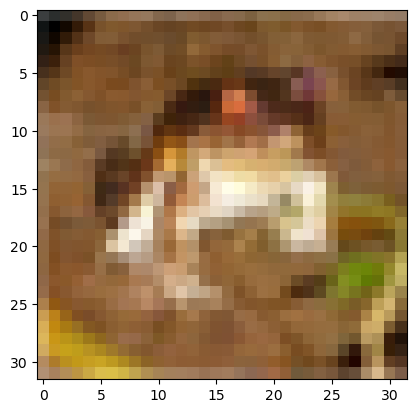

Label: 6


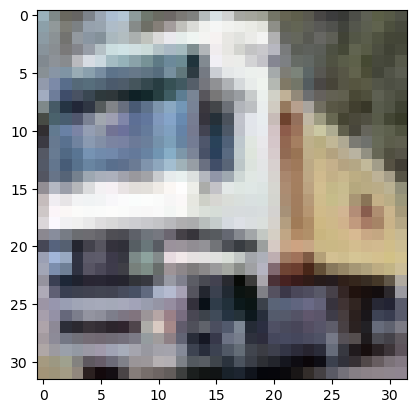

Label: 9


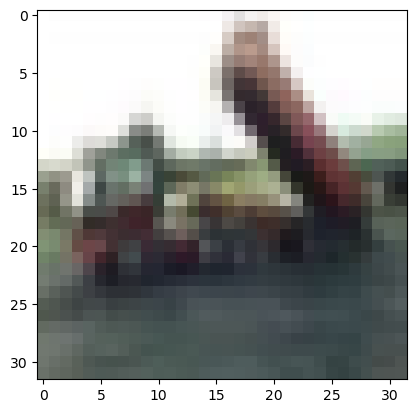

Label: 9


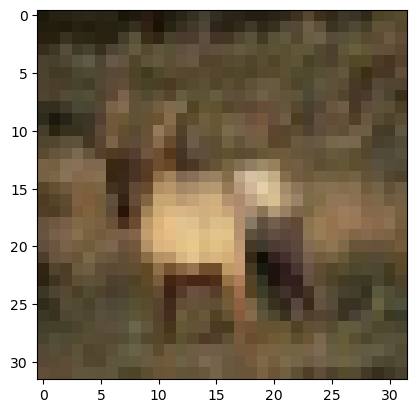

Label: 4


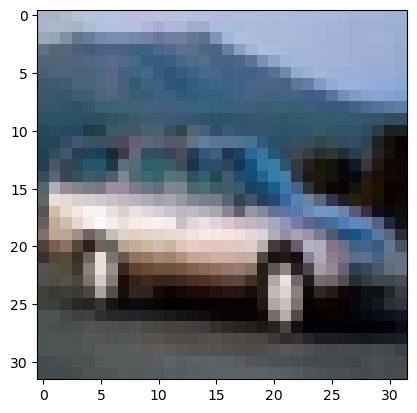

Label: 1


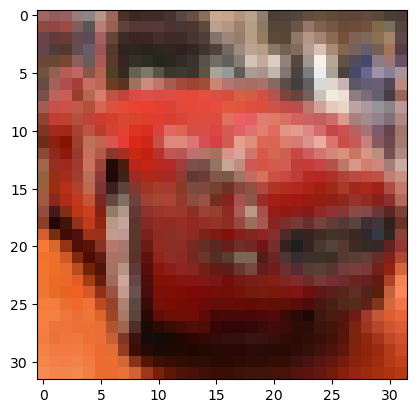

Label: 1


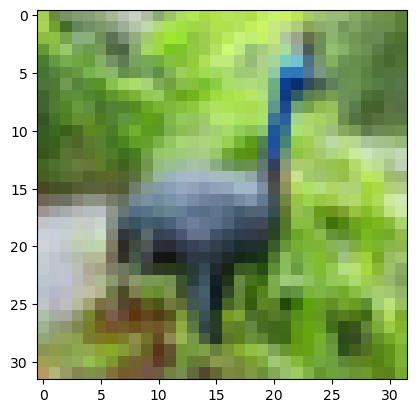

Label: 2


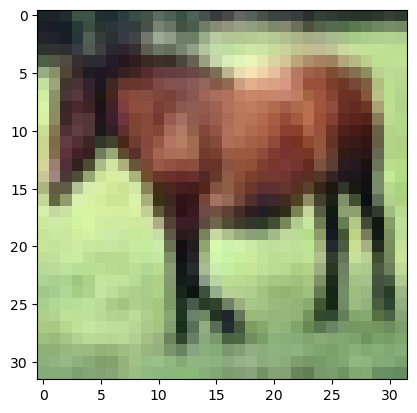

Label: 7


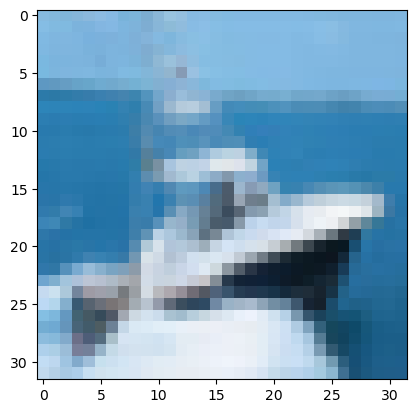

Label: 8


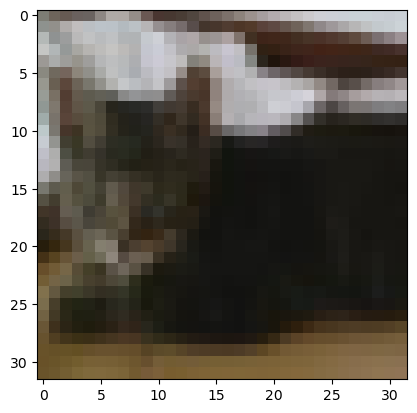

Label: 3


In [16]:
from matplotlib import pyplot as plt


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


for i, (img, label) in enumerate(trainset):
    if i >= 5:  # Stop after 5 images
        break
    imshow(img)
    print(f"Label: {label}")

In [19]:
def mean_brightness_directly(dataset):
    total_brightness = 0.0
    num_images = 0
    
    # Iterate through all images in the dataset
    for image, _ in dataset:
        # image shape is (3, 32, 32)
        # Take mean across all values (channels and pixels)
        total_brightness += image.mean().item()
        num_images += 1
    
    # Calculate mean brightness across all images
    mean_brightness = total_brightness / num_images
    
    return mean_brightness

In [8]:
def mean_brightness_directly(dataset):
    # Create a DataLoader to load all images at once
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    # Get the single batch containing all images
    images, _ = next(iter(dataloader))
    
    # Calculate mean across all dimensions: batch, channels, height, width
    return images.mean().item()

In [10]:
assert abs(mean_brightness_directly(trainset) - 0.4733) < 1e-4

### Problem 3: Data loaders
Find the mean brightness of CIFAR-10 images by iterating through the dataset using a DataLoader with a batch size of 256.

In [25]:
from torch.utils.data import DataLoader

def mean_brightness_dataloader(dataset):
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    
    total_brightness = 0.0
    total_images = 0
    
    # Iterate through batches
    for images, _ in loader:
        total_brightness += images.mean() * len(images)
        total_images += len(images)
    
    # Calculate final mean
    return (total_brightness / total_images).item()

In [27]:
assert abs(mean_brightness_dataloader(trainset) - 0.4733) < 1e-4

### Problem 4: Minimizing a loss function using SGD
Find the mean brightness of CIFAR-10 images in two ways: by iterating through the dataset and summing the pixel intensities and with stochastic gradient descent, by minimizing squared error.

In [29]:
def mean_brightness_sgd(dataset):
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    cur_mean = torch.zeros(1)
    cur_mean.requires_grad_(True)
    
    optimizer = torch.optim.SGD([cur_mean], lr=0.1)
    
    for epoch in range(1):
        for images, _ in loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Calculate MSE loss between cur_mean and batch mean
            batch_mean = images.mean()
            loss = (cur_mean - batch_mean) ** 2
            
            # Backpropagate and update
            loss.backward()
            optimizer.step()
    
    return cur_mean.data.item()

In [ ]:
assert abs(mean_brightness_sgd(trainset) - 0.4733) < 1e-2